In [99]:
import pandas as pd
import numpy as np
import re
from scipy.special import psi  # gamma function utils
from pprint import pprint
import gensim.corpora as corpora
from gensim.corpora import Dictionary
import nltk
from nltk.corpus import reuters
nltk.download('reuters')
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

[nltk_data] Downloading package reuters to /home/lyann/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [69]:
stop_words = ["would", "could", "said", "u", "us", "also", "may", "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [70]:
## Utils and Helper Class

def tf(docs):
    """
    This function is used to calculate the document-term matrix and id2word mapping
    """
    # Clean up the text
    docsc_clean = {}
    total_term = []
    for key, val in enumerate(docs):
        val_clean = re.findall(r'[a-z]+', val.lower())
        val_clean = [i for i in val_clean if i not in stop_words]
        docsc_clean[f'd{key}'] = val_clean
        total_term += val_clean

    total_term_unique = sorted(set(total_term))
    id2word = {idx: word for  idx, word in enumerate(total_term_unique)}

    # Count the number of occurrences of term i in document j
    for key, val in docsc_clean.items():
        word_dir = dict.fromkeys(total_term_unique, 0)
        for word in val:
            word_dir[word] += 1
        docsc_clean[key] = word_dir

    tf_df = pd.DataFrame.from_dict(docsc_clean, orient='index')

    return tf_df, id2word

def dirichlet_expectation(sstats):
    if len(sstats.shape) == 1:
        return psi(sstats) - psi(np.sum(sstats))
    else:
        return psi(sstats) - psi(np.sum(sstats, 1))[:, np.newaxis]
    
    
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

class LdaState:
    def __init__(self, eta, shape, dtype=np.float32):
        """
        Parameters
        ----------
        eta : numpy.ndarray
            The prior probabilities assigned to each term.
        shape : tuple of (int, int)
            Shape of the sufficient statistics: (number of topics to be found, number of terms in the vocabulary).
        dtype : type
            Overrides the numpy array default types.

        """
        self.eta = eta.astype(dtype, copy=False)
        self.sstats = np.zeros(shape, dtype=dtype)
        self.numdocs = 0
        self.dtype = dtype

    def get_lambda(self):
        """Get the parameters of the posterior over the topics, also referred to as "the topics".

        Returns
        -------
        numpy.ndarray
            Parameters of the posterior probability over topics.

        """
        return self.eta + self.sstats

    def get_Elogbeta(self):
        """Get the log (posterior) probabilities for each topic.

        Returns
        -------
        numpy.ndarray
            Posterior probabilities for each topic.
        """
        return dirichlet_expectation(self.get_lambda())

    def blend(self, rhot, other, targetsize=None):
        """Merge the current state with another one using a weighted average for the sufficient statistics.

        The number of documents is stretched in both state objects, so that they are of comparable magnitude.
        This procedure corresponds to the stochastic gradient update from
        `Hoffman et al. :"Online Learning for Latent Dirichlet Allocation"
        <https://www.di.ens.fr/~fbach/mdhnips2010.pdf>`_, see equations (5) and (9).

        Parameters
        ----------
        rhot : float
            Weight of the `other` state in the computed average. A value of 0.0 means that `other`
            is completely ignored. A value of 1.0 means `self` is completely ignored.
        other : :class:`~gensim.models.ldamodel.LdaState`
            The state object with which the current one will be merged.
        targetsize : int, optional
            The number of documents to stretch both states to.

        """
        assert other is not None
        if targetsize is None:
            targetsize = self.numdocs

        # stretch the current model's expected n*phi counts to target size
        if self.numdocs == 0 or targetsize == self.numdocs:
            scale = 1.0
        else:
            scale = 1.0 * targetsize / self.numdocs
        self.sstats *= (1.0 - rhot) * scale

        # stretch the incoming n*phi counts to target size
        if other.numdocs == 0 or targetsize == other.numdocs:
            scale = 1.0
        else:
            scale = 1.0 * targetsize / other.numdocs
        self.sstats += rhot * scale * other.sstats
        self.numdocs = targetsize

In [71]:
def my_lda_func(corpus, num_topics, id2word, random_state=10,  passes=1, num_words=10,
                iterations=50, gamma_threshold=0.001, dtype=np.float32,  chunksize=100, topics_only=True, verbose=False):
    num_terms = len(id2word)

    alpha = np.array( [1.0 / num_topics for i in range(num_topics)], dtype=dtype)

    eta = np.array( [1.0 / num_topics for i in range(num_terms)], dtype=dtype)

    rand  = np.random.RandomState(random_state)

    model_states = LdaState(eta, (num_topics, num_terms), dtype=dtype)
    model_states.sstats = rand.gamma(100., 1. / 100., (num_topics, num_terms))

    expElogbeta = np.exp(dirichlet_expectation(model_states.sstats))


    # Update
    lencorpus = len(corpus)
    chunksize = min(lencorpus, chunksize)
    model_states.numdocs += lencorpus
    num_updates = 0

    for pass_ in range(passes):
        all_chunks = chunks(corpus, chunksize)
        gamma_by_chunks = []
        for chunk_no, chunk in enumerate(all_chunks):
            other = LdaState(eta, (num_topics, num_terms), dtype=dtype)
            # Do estep
            if len(chunk) > 1:
                if verbose:
                    print(f'performing inference on a chunk of {len(chunk) } documents')
            else:
                raise

            # Initialize the variational distribution q(theta|gamma) for the chunk
            gamma = rand.gamma(100., 1. / 100., (len(chunk), num_topics)).astype(dtype, copy=False)
            tmpElogtheta = dirichlet_expectation(gamma)
            tmpexpElogtheta = np.exp(tmpElogtheta)
            sstats = np.zeros_like(expElogbeta, dtype=dtype)
            converged = 0

            # Now, for each document d update that document's gamma and phi
            epsilon = 1e-7

            for d, doc in enumerate(chunk):
                ids = [idx for idx, _ in doc]
                cts = np.fromiter((cnt for _, cnt in doc), dtype=dtype, count=len(doc))
                gammad = gamma[d, :]
                Elogthetad = tmpElogtheta[d, :]
                expElogthetad = tmpexpElogtheta[d, :]
                expElogbetad = expElogbeta[:, ids]

                # The optimal phi_{dwk} is proportional to expElogthetad_k * expElogbetad_w.
                # phinorm is the normalizer.
                phinorm = np.dot(expElogthetad, expElogbetad) + epsilon

                for _ in range(iterations):
                    lastgamma = gammad
                    # We represent phi implicitly to save memory and time.
                    # Substituting the value of the optimal phi back into
                    # the update for gamma gives this update. Cf. Lee&Seung 2001.
                    gammad = alpha + expElogthetad * np.dot(cts / phinorm, expElogbetad.T)
                    Elogthetad = dirichlet_expectation(gammad)
                    expElogthetad = np.exp(Elogthetad)
                    phinorm = np.dot(expElogthetad, expElogbetad) + epsilon
                    # If gamma hasn't changed much, we're done.
                    meanchange = np.mean(np.abs(gammad - lastgamma))
                    if meanchange < gamma_threshold:
                        converged += 1
                        break
                gamma[d, :] = gammad
                sstats[:, ids] += np.outer(expElogthetad.T, cts / phinorm)
                gamma_by_chunks.append(gamma)

            if len(chunk) > 1:
                if verbose:
                    print(f"{converged}/{len(chunk)} documents converged within {iterations} iterations")

            sstats *= expElogbeta

            other.sstats += sstats
            other.numdocs += gamma.shape[0]

            # Do mstep
            if verbose:
                print('Update topics')
            previous_Elogbeta = model_states.get_Elogbeta()
            rho = pow(1 + pass_ + (num_updates / chunksize), -0.5)
            model_states.blend(rho, other)

            current_Elogbeta = model_states.get_Elogbeta()
            #Propagate the states topic probabilities to the inner object's attribute.
            expElogbeta = np.exp(current_Elogbeta)

            diff = np.mean(np.abs(previous_Elogbeta.ravel() - current_Elogbeta.ravel()))
            if verbose:
                print(f"topic diff {diff}")
            num_updates += other.numdocs

    shown = []
    topic = model_states.get_lambda()

    for i in range(num_topics):
        topic_ = topic[i]
        topic_ = topic_ / topic_.sum()  # normalize to probability distribution
        bestn = topic_.argsort()[-num_words:][::-1]

        topic_ = [(id2word[id], topic_[id]) for id in bestn]
        topic_ = ' + '.join('%.3f*"%s"' % (v, k) for k, v in topic_)
        shown.append((i, topic_))

    if topics_only:
        return shown
    else:
        return shown,gamma_by_chunks

## For Carol: Small test data (d1 to d5)

In [88]:
# Sample data for analysis
d1 = "Java is a language for programming that develops a software for several platforms. A compiled code or bytecode on Java application can run on most of the operating systems including Linux, Mac operating system, and Linux. Most of the syntax of Java is derived from the C++ and C languages."
d2 = "Python supports multiple programming paradigms and comes up with a large standard library, paradigms included are object-oriented, imperative, functional and procedural."
d3 = "Go is typed statically compiled language. It was created by Robert Griesemer, Ken Thompson, and Rob Pike in 2009. This language offers garbage collection, concurrency of CSP-style, memory safety, and structural typing."
d4 = "A young girl when she first visited magical Underland, Alice Kingsleigh (Mia Wasikowska) is now a teenager with no memory of the place -- except in her dreams."
d5 = "Her life takes a turn for the unexpected when, at a garden party for her fiance and herself, she spots a certain white rabbit and tumbles down a hole after him. Reunited with her friends the Mad Hatter (Johnny Depp), the Cheshire Cat and others, Alice learns it is her destiny to end the Red Queen's (Helena Bonham Carter) reign of terror."

In [92]:
# Using slow version tf_df
tf_df, id2word = tf([d1, d2, d3, d4, d5])

lil = []
for row in tf_df.values:
    lil_sub = []
    for idx, item in enumerate(row):
        if item:
            lil_sub.append((idx, item))
    lil.append(lil_sub)
    
shown, gamma_by_chunks = my_lda_func(corpus=lil, num_topics=2, id2word=id2word, topics_only=False, num_words=10, verbose=True, passes=10)

performing inference on a chunk of 5 documents
0/5 documents converged within 50 iterations
Update topics
topic diff 0.5658777670609699
performing inference on a chunk of 5 documents
4/5 documents converged within 50 iterations
Update topics
topic diff 0.20531260303613888
performing inference on a chunk of 5 documents
5/5 documents converged within 50 iterations
Update topics
topic diff 0.09956979691972542
performing inference on a chunk of 5 documents
5/5 documents converged within 50 iterations
Update topics
topic diff 0.051361470709214804
performing inference on a chunk of 5 documents
5/5 documents converged within 50 iterations
Update topics
topic diff 0.02989384244714881
performing inference on a chunk of 5 documents
5/5 documents converged within 50 iterations
Update topics
topic diff 0.018735256899534262
performing inference on a chunk of 5 documents
5/5 documents converged within 50 iterations
Update topics
topic diff 0.012360083784749917
performing inference on a chunk of 5 do

In [93]:
shown

[(0,
  '0.023*"language" + 0.014*"alice" + 0.014*"memory" + 0.014*"compiled" + 0.014*"concurrency" + 0.014*"go" + 0.014*"safety" + 0.014*"griesemer" + 0.014*"collection" + 0.014*"csp"'),
 (1,
  '0.032*"java" + 0.023*"operating" + 0.023*"linux" + 0.023*"paradigms" + 0.023*"c" + 0.023*"programming" + 0.014*"language" + 0.014*"compiled" + 0.014*"systems" + 0.014*"mac"')]

In [94]:
gamma_by_chunks

[array([[ 0.5350382, 27.464731 ],
        [ 0.5197944, 16.48005  ],
        [23.458965 ,  0.5408032],
        [ 0.548567 , 15.451267 ],
        [33.47377  ,  0.5258844]], dtype=float32),
 array([[ 0.5350382, 27.464731 ],
        [ 0.5197944, 16.48005  ],
        [23.458965 ,  0.5408032],
        [ 0.548567 , 15.451267 ],
        [33.47377  ,  0.5258844]], dtype=float32),
 array([[ 0.5350382, 27.464731 ],
        [ 0.5197944, 16.48005  ],
        [23.458965 ,  0.5408032],
        [ 0.548567 , 15.451267 ],
        [33.47377  ,  0.5258844]], dtype=float32),
 array([[ 0.5350382, 27.464731 ],
        [ 0.5197944, 16.48005  ],
        [23.458965 ,  0.5408032],
        [ 0.548567 , 15.451267 ],
        [33.47377  ,  0.5258844]], dtype=float32),
 array([[ 0.5350382, 27.464731 ],
        [ 0.5197944, 16.48005  ],
        [23.458965 ,  0.5408032],
        [ 0.548567 , 15.451267 ],
        [33.47377  ,  0.5258844]], dtype=float32)]

## Simulated Data (Sleep & Vaccine Policy)

In [163]:
sleep = pd.read_csv('sleep_diet_exercise.csv', header=None)

In [164]:
docs = [i[0] for i in sleep.values]
len(docs)

30

In [185]:
tf_df, id2word = tf(docs)

lil = []
for row in tf_df.values:
    lil_sub = []
    for idx, item in enumerate(row):
        if item:
            lil_sub.append((idx, item))
    lil.append(lil_sub)
    
simu_result = my_lda_func(corpus=lil, num_topics=2, id2word=id2word, num_words=10, chunksize=20, passes=10, verbose=False)

In [222]:
simu_result

[(0,
  '0.060*"sleep" + 0.022*"exercise" + 0.009*"activity" + 0.008*"studies" + 0.008*"adults" + 0.008*"health" + 0.007*"physical" + 0.007*"poor" + 0.007*"quality" + 0.006*"insomnia"'),
 (1,
  '0.012*"biden" + 0.007*"president" + 0.007*"pandemic" + 0.006*"tax" + 0.005*"administration" + 0.005*"vaccine" + 0.005*"vaccines" + 0.005*"covid" + 0.004*"americans" + 0.004*"first"')]

In [204]:
def parse_result(result):
    """
    This function is used to reorganize the result of my_lda_func.
    """
    result_dic = {}
    for topic_num, dist in result:
        unpack = []
        for obj in dist.split('+'):
            prob, word = obj.split('*')
            unpack.append((float(prob), word.strip().strip('"')))
        prob, word = zip(*unpack)
        result_dic[topic_num] = [prob, word]
    return result_dic

In [223]:
# Parsed result for simulated data
simulated_data_result = parse_result(simu_result)
simulated_data_result

{0: [(0.06, 0.022, 0.009, 0.008, 0.008, 0.008, 0.007, 0.007, 0.007, 0.006),
  ('sleep',
   'exercise',
   'activity',
   'studies',
   'adults',
   'health',
   'physical',
   'poor',
   'quality',
   'insomnia')],
 1: [(0.012, 0.007, 0.007, 0.006, 0.005, 0.005, 0.005, 0.005, 0.004, 0.004),
  ('biden',
   'president',
   'pandemic',
   'tax',
   'administration',
   'vaccine',
   'vaccines',
   'covid',
   'americans',
   'first')]}

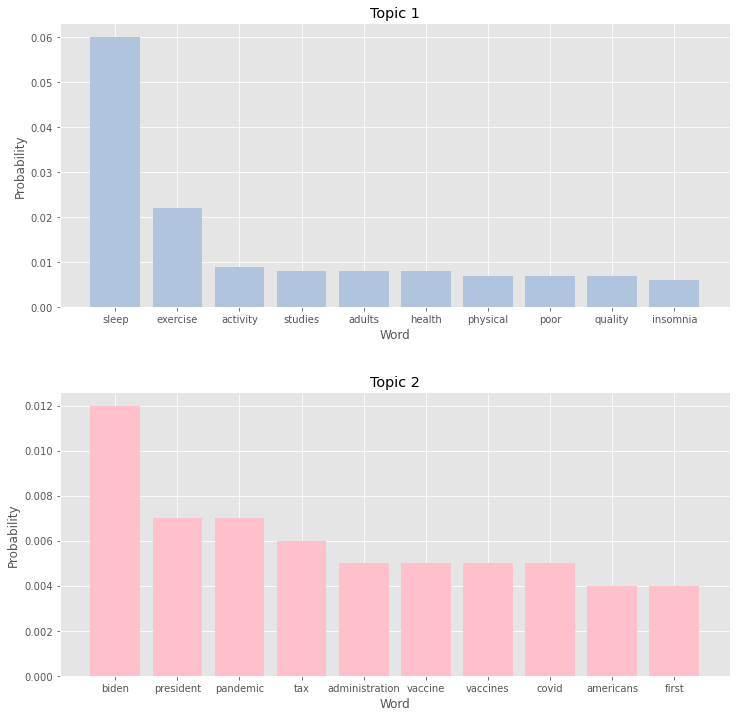

In [226]:
# Bar plots for simulated data
fig, axs = plt.subplots(2, 1, figsize=(12, 12))
cmap = ['lightsteelblue', 'pink', 'darkgrey', 'khaki', 'lightsalmon', 'darkseagreen']

# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.3)
simu_dic = parse_result(simu_result)

for idx, ax in enumerate(axs):
    probability, words = simu_dic[idx]

    ax.bar(words, probability, color=cmap[idx])
    ax.set_xlabel("Word")
    ax.set_ylabel("Probability")
    ax.set_title(f"Topic {idx+1}")

# plt.savefig('figures/simulated_data_result.jpg')
plt.show()

## Real-world Data 1: Reuters

In [227]:
np.random.seed(1)
ntotal=1000
documents = reuters.fileids()
documents=np.random.choice(documents,ntotal)
docs=[reuters.raw(d) for d in documents]

In [228]:
len(docs)

1000

In [229]:
tf_df, id2word = tf(docs)

lil = []
for row in tf_df.values:
    lil_sub = []
    for idx, item in enumerate(row):
        if item:
            lil_sub.append((idx, item))
    lil.append(lil_sub)
    
real_result_1 = my_lda_func(corpus=lil, num_topics=4, id2word=id2word, num_words=10, chunksize=20, passes=10)

In [230]:
# Parsed result for real data 1 from Reuters
reuters_data_result = parse_result(real_result_1)
reuters_data_result

{0: [(0.011, 0.008, 0.007, 0.006, 0.006, 0.005, 0.005, 0.005, 0.004, 0.004),
  ('tonnes',
   'japan',
   'trade',
   'mln',
   'oil',
   'ec',
   'officials',
   'production',
   'told',
   'countries')],
 1: [(0.025, 0.016, 0.015, 0.011, 0.011, 0.011, 0.011, 0.009, 0.009, 0.009),
  ('lt',
   'dlrs',
   'company',
   'corp',
   'inc',
   'shares',
   'stock',
   'mln',
   'pct',
   'offer')],
 2: [(0.08, 0.072, 0.047, 0.04, 0.037, 0.028, 0.024, 0.02, 0.018, 0.018),
  ('vs', 'mln', 'cts', 'net', 'dlrs', 'loss', 'shr', 'lt', 'profit', 'year')],
 3: [(0.026, 0.018, 0.016, 0.011, 0.009, 0.009, 0.009, 0.008, 0.007, 0.007),
  ('pct',
   'year',
   'billion',
   'bank',
   'mln',
   'last',
   'dlrs',
   'rate',
   'february',
   'rates')]}

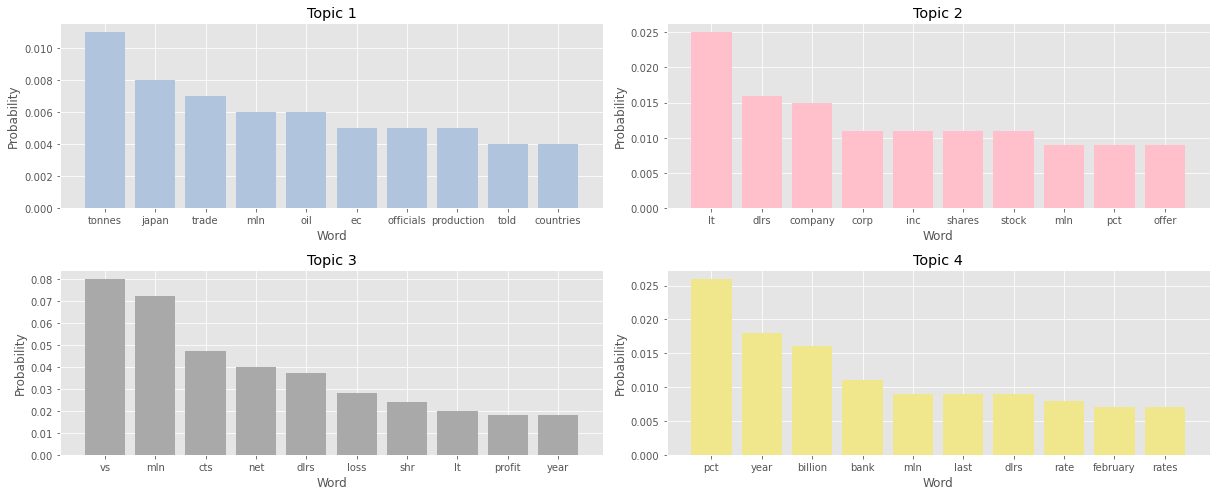

In [262]:
# Bar plots for simulated data
fig, axs = plt.subplots(2, 2, figsize=(17, 7))
cmap = ['lightsteelblue', 'pink', 'darkgrey', 'khaki', 'lightsalmon', 'darkseagreen']

# make a little extra space between the subplots
simu_dic = parse_result(real_result_1)

for idx, ax in enumerate(axs.ravel()):
    probability, words = simu_dic[idx]

    ax.bar(words, probability, color=cmap[idx])
    ax.set_xlabel("Word")
    ax.set_ylabel("Probability")
    ax.set_title(f"Topic {idx+1}")

plt.tight_layout()
plt.savefig('figures/reuters_data_result.jpg')
plt.show()

## Real-world Data 2: Tweet

In [238]:
# Real world sample data
raw_tweets = pd.read_csv('clean_tweets.csv')

tweets_list = raw_tweets.Tweets.values.tolist()

# Turn the list of string into a list of tokens
clean_tweets = [t.split(',') for t in tweets_list]

len(clean_tweets)

6000

In [239]:
id2word = Dictionary(clean_tweets)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in clean_tweets]

In [240]:
real_result_2 = my_lda_func(corpus=corpus, num_topics=6, id2word=id2word, num_words=10, chunksize=100, passes=10)

In [246]:
# Parsed result for real data 2 from Tweet
tweet_data_result = parse_result(real_result_2)
tweet_data_result

{0: [(0.067, 0.049, 0.019, 0.012, 0.012, 0.012, 0.011, 0.01, 0.007, 0.007),
  ('late',
   'thank',
   'app',
   'daily',
   'wind',
   'mph',
   'c',
   'cloud',
   'humidity',
   'mb')],
 1: [(0.018, 0.011, 0.01, 0.008, 0.006, 0.006, 0.006, 0.005, 0.005, 0.005),
  ('trump',
   'people',
   'say',
   'think',
   'know',
   'right',
   'need',
   'vote',
   'go',
   'woman')],
 2: [(0.013, 0.011, 0.01, 0.01, 0.01, 0.009, 0.008, 0.008, 0.008, 0.007),
  ('good',
   'go',
   'love',
   'day',
   'thank',
   'time',
   'think',
   'look',
   'year',
   'know')],
 3: [(0.011, 0.011, 0.009, 0.007, 0.006, 0.005, 0.005, 0.004, 0.004, 0.004),
  ('new',
   'great',
   'thank',
   'how',
   'work',
   'good',
   'year',
   'help',
   'need',
   'change')],
 4: [(0.097, 0.079, 0.069, 0.064, 0.039, 0.034, 0.025, 0.022, 0.017, 0.014),
  ('video',
   'like',
   'follow',
   'check',
   'automatically',
   'people',
   'unfollowed',
   'person',
   'follower',
   'new')],
 5: [(0.137, 0.044, 0.018, 0.0

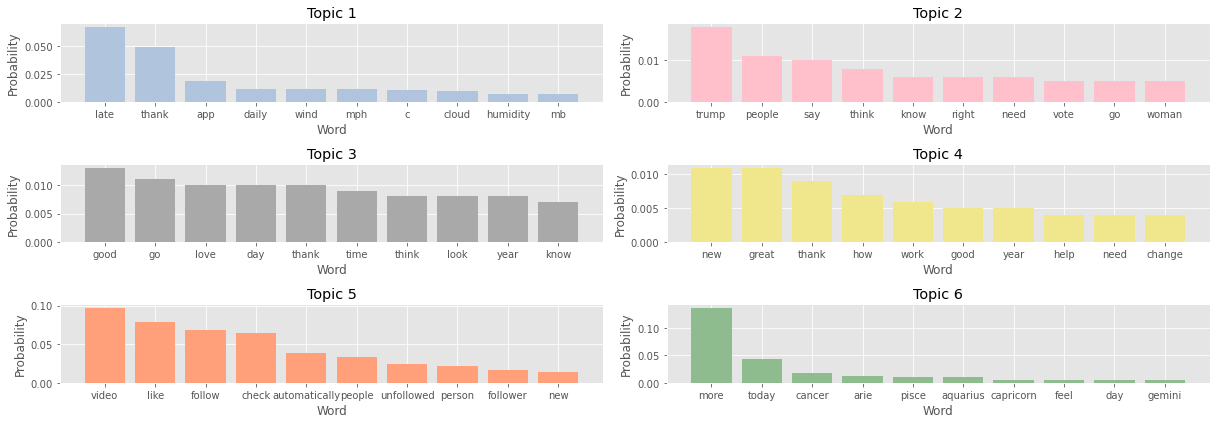

In [258]:
# Bar plots for simulated data
fig, axs = plt.subplots(3, 2, figsize=(17, 6))
cmap = ['lightsteelblue', 'pink', 'darkgrey', 'khaki', 'lightsalmon', 'darkseagreen']

# make a little extra space between the subplots
simu_dic = parse_result(real_result_2)

for idx, ax in enumerate(axs.ravel()):
    probability, words = simu_dic[idx]

    ax.bar(words, probability, color=cmap[idx])
    ax.set_xlabel("Word")
    ax.set_ylabel("Probability")
    ax.set_title(f"Topic {idx+1}")

plt.tight_layout()
# plt.savefig('figures/tweet_data_result.jpg')
plt.show()